# 3.1.3 Optimización usando Early-stopping

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
import numpy as np

import math

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

## 3.1.3.1 Definición del problema

Polinomio de grado $n$ con parámetros óptimos:

$$ y = 1.2 + 0.5x − 0.8x^2 $$

Obtención trivial de un polinomio de grado $n+1$ con el mismo comportamiento del polinomio de grado $n$:

$$ y = 1.2 + 0.5x − 0.8x^2 + 0x^3 $$

Polinomio de grado $n+1$ con parámetros óptimos:

$$ y = 0.9 + 0.1x − 0.7x^2 + 0.05x^3 $$

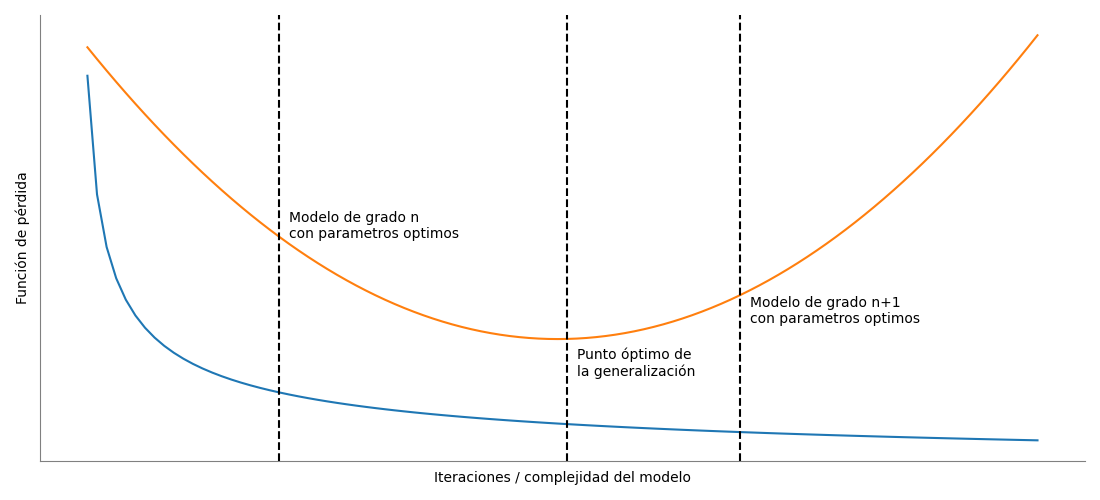

## 3.1.3.2 Función a aproximar usando un modelo de regresión

$$
\begin{align}

Eg(X)=\begin{Bmatrix}

 \exp (0.15x + 1), & x < 5 
 
 \\ 
 
 \exp (0.25x + 1), & x >= 5 

\end{Bmatrix}

\end{align}
$$

In [20]:
#
# Función a aproximar
# (Proceso geneador de datos)
#
def f(x):
    y = [math.exp(0.15 * u + 1) if u < 5 else math.exp(0.25 * u + 1) for u in x]
    return np.array(y)


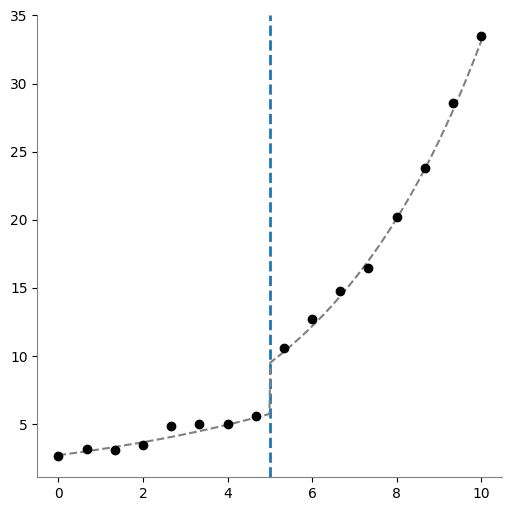

In [21]:
np.random.seed(12345)

x_real = np.linspace(start=0, stop=10, num=500)
x_data = np.linspace(start=0, stop=10, num=16)

d_real = f(x_real)
d_data = f(x_data) + np.random.normal(0, 0.4, len(x_data))

plt.figure(figsize=(6, 6))
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axvline(5, linestyle="--", color="tab:blue", linewidth=2)
plt.plot(x_real, d_real, "--", color="gray")
plt.plot(x_data, d_data, "o", color="black")
plt.show()

## 3.1.3.3 Partición del conjunto de datos

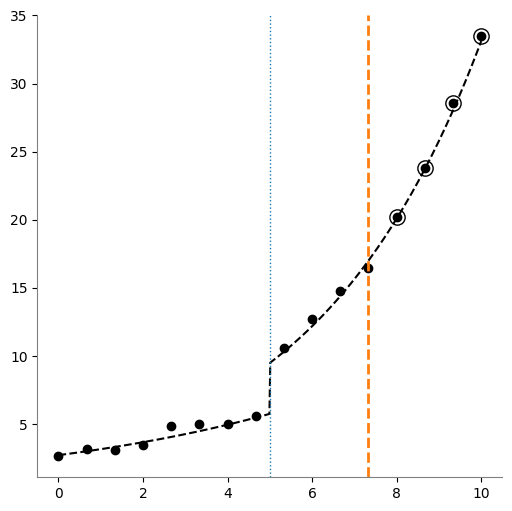

In [22]:
# selecciona los primeros elementos del conjunto de datos
# para calibración y los 4 finales para testing
index = list(range(12))

# muestra usada para estimar los parámetros del modelo
x_fit = x_data[index]
d_fit = d_data[index]

# muestra usada para evaluar la generalización
x_test = np.delete(x_data, index)
d_test = np.delete(d_data, index)

plt.figure(figsize=(6, 6))

plt.plot(x_data, d_data, "o", color="black")
plt.plot(x_real, d_real, "--", color="black")
plt.plot(x_test, d_test, "o", color="black", fillstyle="none", markersize=11)
plt.axvline(5, linestyle=":", color="tab:blue", linewidth=1)
plt.axvline(x_data[11], linestyle="--", color="tab:orange", linewidth=2)
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

## 3.1.3.4 Modelo de regresión

$$ y = g(x) = exp(w_0 + w_1x) $$

In [23]:
def g(w0, w1, x):
    return [math.exp(w0 + w1 * xi) for xi in x]

## 3.1.3.5 Función de pérdida

$$ SSE(w_0, w_1) = \sum_{i}{} [d_i - g(x_i)]^2 $$

In [24]:
def SSE(w0, w1):

    y_fit = g(w0, w1, x_fit)
    sse_fit = sum([(di - yi) ** 2 for di, yi in zip(d_fit, y_fit)])

    y_test = g(w0, w1, x_test)
    sse_test = sum([(di - yi) ** 2 for di, yi in zip(d_test, y_test)])

    #
    # note que la función devuelve simultaneamente
    # los errores de ajuste y prueba
    #
    return sse_fit, sse_test

## 3.1.3.6 Gradiente de g()

Gradiente respecto a $W_0$:

$$ \frac{\delta}{\delta W_0}g(x) = \frac{\delta}{\delta W_0} [exp(w_0 + w_1x)]  $$
$$ = exp(w_0 + w_1x) \frac{\delta}{\delta W_0}(w_0 + w_1x) $$
$$ = exp(w_0 + w_1x)*1 $$
$$ = exp(w_0 + w_1x) $$
$$ = g(x) $$

Gradente respecto a $w_1$

$$ \frac{\delta}{\delta W_1}g(x) = \frac{\delta}{\delta W_1} [exp(w_0 + w_1x)]  $$
$$ exp(w_0 + w_1x) \frac{\delta}{\delta W_0}(w_0 + w_1x) $$
$$ exp(w_0 + w_1x)*1 $$
$$ exp(w_0 + w_1x) $$
$$ g(x) $$

In [25]:
def grd_g(w0, w1):
    grd_w0 = g(w0, w1, x_fit)
    grd_w1 = [gi * xi for gi, xi in zip(grd_w0, x_fit)]
    return grd_w0, grd_w1

## 3.1.3.7 Gradiente de la función de pérdida

$$ \frac{\delta}{\delta W_j}SSE(w_0, w_1) = \frac{\delta}{\delta W_j} \sum_{i}{} e_i^2  $$
$$ = \sum_{i}{} \frac{\delta}{\delta W_j}  e_i^2  $$
$$ = \sum_{i}{} 2 * e_i \frac{\delta}{\delta W_j} e_i $$
$$ = \sum_{i}{} 2 * e_i \frac{\delta}{\delta W_j} [d_i - g(x_i)] $$
$$ = \sum_{i}{} 2 * e_i \frac{\delta}{\delta W_j} -g(x_i) $$
$$ = \sum_{i}{} -2 * e_i \frac{\delta}{\delta W_j} g(x_i) $$

In [26]:
def grd_SSE(w0, w1):

    # calcula el error instantaneo
    y_fit = g(w0, w1, x_fit)
    e_fit = [di - yi for di, yi in zip(d_fit, y_fit)]

    # gradiente de la funcion g()
    grd_gw0, grd_gw1 = grd_g(w0, w1)

    # gradiente de la función SSE()
    grd_SSE_w0 = sum([-2 * ei * gi for ei, gi in zip(e_fit, grd_gw0)])
    grd_SSE_w1 = sum([-2 * ei * gi for ei, gi in zip(e_fit, grd_gw1)])

    return grd_SSE_w0, grd_SSE_w1

## 3.1.3.8 Corrección de los parámetros

$$ w_k = w_{k-1} - \mu \frac{\delta}{\delta_w}SSE(w_{k-1}) $$

In [27]:
def mejora(w0, w1, mu):
    grd_w0, grd_w1 = grd_SSE(w0, w1)
    w0 = w0 - mu * grd_w0
    w1 = w1 - mu * grd_w1
    return w0, w1

## 3.1.3.9 Proceso iterativo usando gradiente descendente

0.07770616845298249 0.3869431892967564 (25.447857365832416, 530.3035876747726)


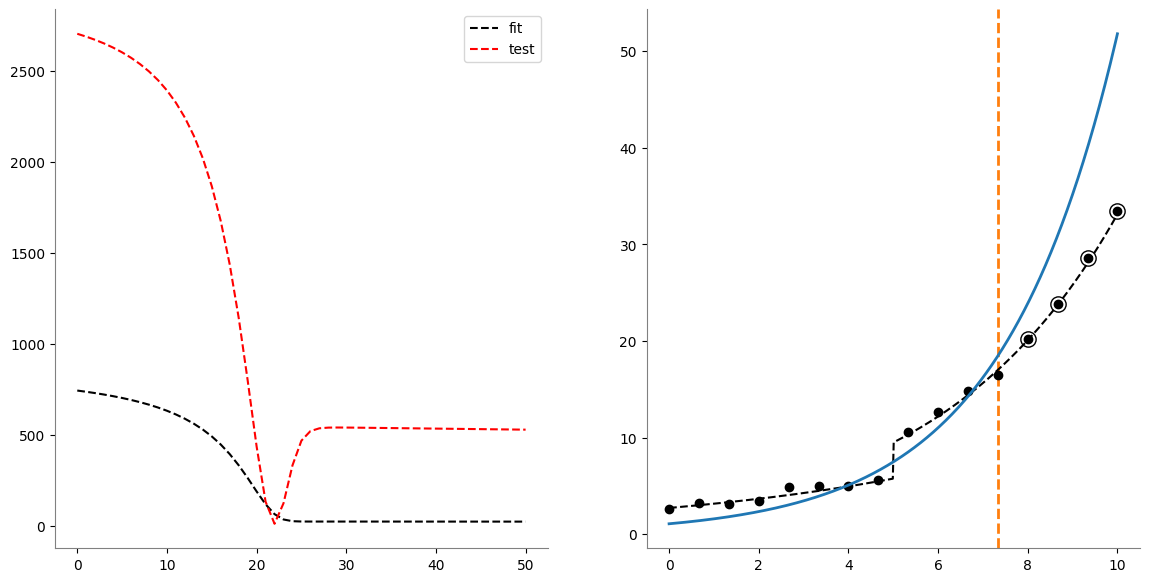

In [28]:
w0, w1 = 0.0, 0.0  # coeficientes iniciales

sse_fit, sse_test = SSE(w0, w1)
history_sse_fit = [sse_fit]
history_sse_test = [sse_test]

for epoch in range(50):
    w0, w1 = mejora(w0, w1, mu=0.00001)
    sse_fit, sse_test = SSE(w0, w1)
    history_sse_fit.append(sse_fit)
    history_sse_test.append(sse_test)

print(w0, w1, SSE(w0, w1))

y_real = g(w0, w1, x_real)


plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(history_sse_fit, "--k", label="fit")
plt.plot(history_sse_test, "--r", label="test")
plt.legend()
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.subplot(1, 2, 2)
plt.axvline(x_data[11], linestyle="--", color="tab:orange", linewidth=2)
plt.plot(x_data, d_data, "o", color="black")
plt.plot(x_real, d_real, "--", color="black")
plt.plot(x_real, y_real, color="tab:blue", linewidth=2)
plt.plot(x_test, d_test, "o", color="black", fillstyle="none", markersize=11)
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

## 3.1.3.10 Early Stopping

0.06428604867279972 0.37000034554740424 (37.25020797644438, 126.18643731436904)


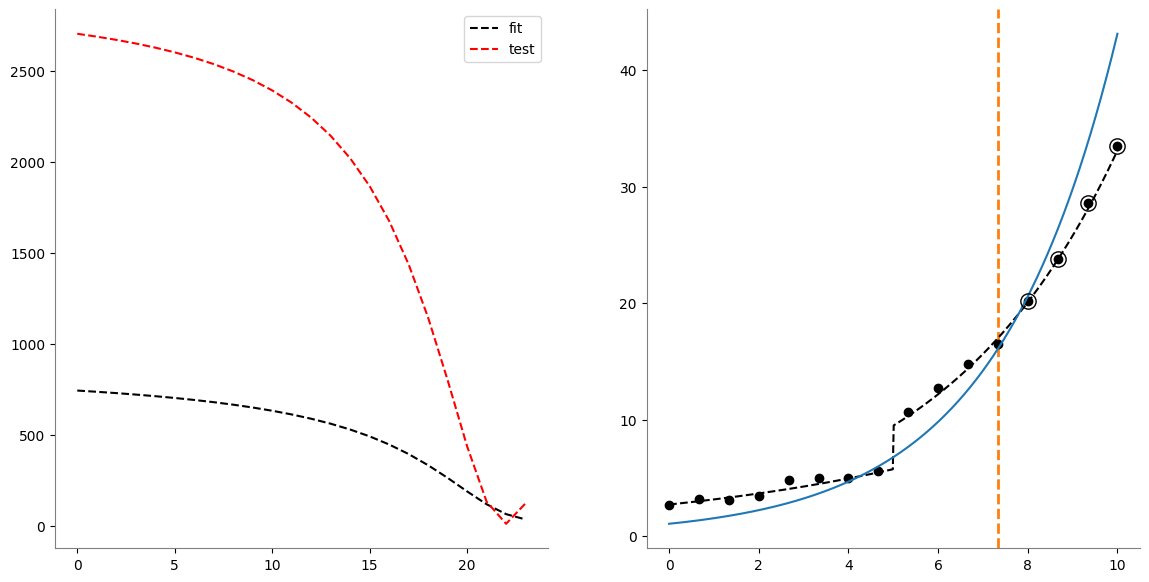

In [29]:
w0, w1 = 0, 0  # coeficientes iniciales

sse_fit, sse_test = SSE(w0, w1)
history_sse_fit = [sse_fit]
history_sse_test = [sse_test]

sse_test_previous = None

for epoch in range(100):
    w0, w1 = mejora(w0, w1, mu=0.00001)
    sse_fit, sse_test = SSE(w0, w1)
    history_sse_fit.append(sse_fit)
    history_sse_test.append(sse_test)
    #
    # Se monitorea sse_test. Si el sse_test
    # aumenta, se detiene la optimización
    #
    if sse_test_previous is None or sse_test_previous > sse_test:
        sse_test_previous = sse_test
    else:
        #
        # aumenta el error de prueba
        #
        break

print(w0, w1, SSE(w0, w1))

y_real = g(w0, w1, x_real)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(history_sse_fit, "--k", label="fit")
plt.plot(history_sse_test, "--r", label="test")
plt.legend()
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.subplot(1, 2, 2)
plt.axvline(x_data[11], linestyle="--", color="tab:orange", linewidth=2)
plt.plot(x_data, d_data, "o", color="black")
plt.plot(x_real, d_real, "--", color="black")
plt.plot(x_real, y_real, color="tab:blue")
plt.plot(x_test, d_test, "o", color="black", fillstyle="none", markersize=11)
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

<module 'matplotlib.pyplot' from '/home/oecorrechag/.local/lib/python3.11/site-packages/matplotlib/pyplot.py'>

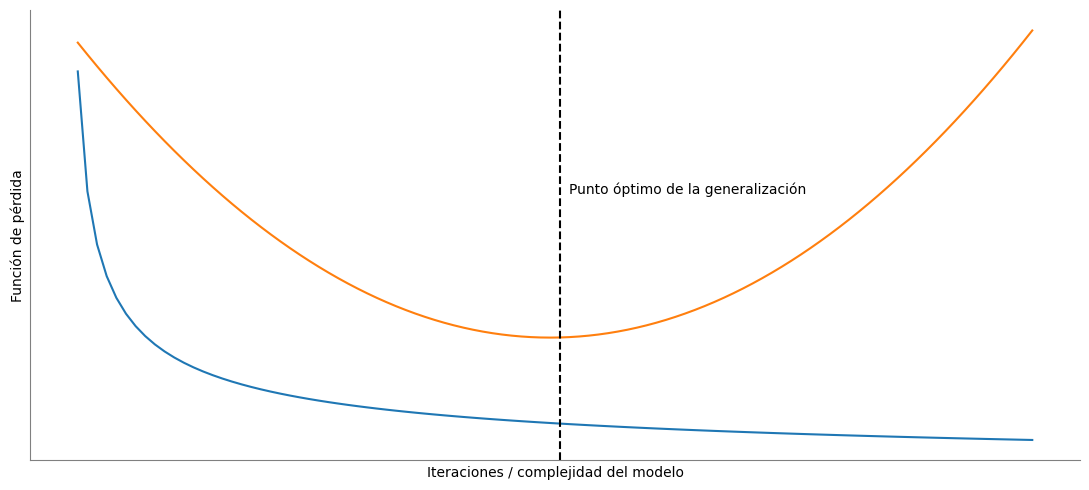

In [35]:
def fig1():

    max_iter = 100
    mu0 = 0.1
    n = 0.5

    learning = [10 * mu0 / (t ** n) for t in range(1, max_iter + 1)]
    test = [0.35 + 0.0003 * (t - 50) ** 2 for t in range(1, max_iter + 1)]

    plt.figure(figsize=(11, 5))

    plt.plot(learning, "-", color="tab:blue", label="Entrenamiento")
    plt.plot(test, "-", color="tab:orange", label="Prueba")
    plt.axvline(50, linestyle="--", color="k")
    plt.text(51, 0.7, "Punto óptimo de la generalización")

    plt.gca().spines["left"].set_color("gray")
    plt.gca().spines["bottom"].set_color("gray")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xlabel("Iteraciones / complejidad del modelo")
    plt.ylabel("Función de pérdida")
    plt.xticks([])
    plt.yticks([])

    plt.tight_layout()
    # plt.savefig("assets/generalizacion.png")
    # plt.close()
    
    return plt


fig1()

In [32]:
print('ok_')

ok_
